In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
import torchvision.transforms as transforms
import random

In [2]:
# load dataset
dataset = h5py.File('data/3dshapes.h5', 'r')
print(dataset.keys())
images = dataset['images']  # array shape [480000,64,64,3], uint8 in range(256)
labels = dataset['labels']  # array shape [480000,6], float64
image_shape = images.shape[1:]  # [64,64,3]
label_shape = labels.shape[1:]  # [6]
n_samples = labels.shape[0]  # 10*10*10*8*4*15=480000
_FACTORS_IN_ORDER = ['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape',
                     'orientation']
_NUM_VALUES_PER_FACTOR = {'floor_hue': 10, 'wall_hue': 10, 'object_hue': 10, 
                          'scale': 8, 'shape': 4, 'orientation': 15}

<KeysViewHDF5 ['images', 'labels']>


In [3]:
# Number of samples to select
n_samples_to_select = 50000

# Randomly sample indices from the total number of samples
random_indices = np.random.choice(n_samples, n_samples_to_select, replace=False)
random_indices.sort()
# Select the sampled images and labels
sampled_images = images[random_indices]
sampled_labels = labels[random_indices]

In [ ]:
normalized_images = sampled_images / 255.0
normalized_images = normalized_images.transpose(0, 3, 1, 2)
print(normalized_images.shape)

(20000, 3, 64, 64)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class Autoencoder(nn.Module):
    def __init__(self, latent_dim=6): # latent dim is 6 because we have 6 factors
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # 64x64 -> 32x32
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 16x16 -> 8x8
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 8x8 -> 4x4
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=4, stride=1, padding=0),  # 4x4 -> 1x1
            nn.ReLU(),
            nn.Conv2d(256, latent_dim, kernel_size=1, stride=1, padding=0),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(latent_dim, 256, 1), 
            nn.ReLU(),
            nn.ConvTranspose2d(256, 256, kernel_size=4, stride=1, padding=0), # 1x1 -> 4x4
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), # 16x16 -> 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  # 32x32 -> 64x64
            nn.Sigmoid()  # Ensures output is within [0,1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
import torch.nn.functional as F

def ae_loss(recon, x):
    # we use sigmoid so we use binary cross entropy rather than MSE to provide a better gradient

    # Reconstruction loss as pixel-wise average
    # reduction='mean' will average across batch, channels, height, and width.
    recon_loss = F.binary_cross_entropy(recon, x, reduction='mean')
    return recon_loss


In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Prepare dataset and dataloader
batch_size = 64
tensor_images = torch.tensor(normalized_images, dtype=torch.float32)
dataset = TensorDataset(tensor_images)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, optimizer, and loss function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Autoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)

# Add learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

previous_lr = scheduler.get_last_lr()

In [ ]:
# Training loop
n_epochs = 15
for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        images = batch[0].to(device)
        optimizer.zero_grad()
        reconstructed = model(images)
        loss = ae_loss(reconstructed, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    
    # Validation loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            images = batch[0].to(device)
            reconstructed = model(images)
            loss = ae_loss(reconstructed, images)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    # Adjust learning rate
    scheduler.step(val_loss)

    # Check if the learning rate has changed
    current_lr = scheduler.get_last_lr()
    if current_lr != previous_lr:
        print(f"Learning rate changed: {previous_lr} -> {current_lr}")
        previous_lr = current_lr
    
    
    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 1/30, Train Loss: 0.0384, Val Loss: 0.0146
Epoch 2/30, Train Loss: 0.0139, Val Loss: 0.0103
Epoch 3/30, Train Loss: 0.0105, Val Loss: 0.0074
Epoch 4/30, Train Loss: 0.0087, Val Loss: 0.0066
Epoch 5/30, Train Loss: 0.0073, Val Loss: 0.0057
Epoch 6/30, Train Loss: 0.0065, Val Loss: 0.0050
Epoch 7/30, Train Loss: 0.0062, Val Loss: 0.0045
Epoch 8/30, Train Loss: 0.0055, Val Loss: 0.0041
Epoch 9/30, Train Loss: 0.0051, Val Loss: 0.0045
Epoch 10/30, Train Loss: 0.0047, Val Loss: 0.0035
Epoch 11/30, Train Loss: 0.0045, Val Loss: 0.0032
Epoch 12/30, Train Loss: 0.0042, Val Loss: 0.0031
Epoch 13/30, Train Loss: 0.0040, Val Loss: 0.0029
Epoch 14/30, Train Loss: 0.0039, Val Loss: 0.0029
Epoch 15/30, Train Loss: 0.0039, Val Loss: 0.0026
Epoch 16/30, Train Loss: 0.0037, Val Loss: 0.0026
Epoch 17/30, Train Loss: 0.0034, Val Loss: 0.0025


KeyboardInterrupt: 

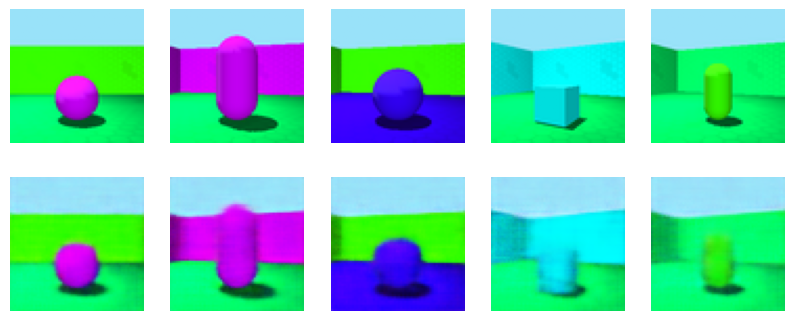

In [89]:
def visualize_reconstruction(model, dataset, n_images=5):
    model.eval()
    indices = random.sample(range(len(dataset)), n_images)
    images = torch.stack([dataset[i][0] for i in indices]).to(device)
    with torch.no_grad():
        reconstructed = model(images)
    
    images = images.cpu().numpy().transpose(0, 2, 3, 1)  # Convert to HWC for visualization
    reconstructed = reconstructed.cpu().numpy().transpose(0, 2, 3, 1)
    
    plt.figure(figsize=(10, 4))
    for i in range(n_images):
        # Original image
        plt.subplot(2, n_images, i+1)
        plt.imshow(images[i])
        plt.axis('off')
        # Reconstructed image
        plt.subplot(2, n_images, i+n_images+1)
        plt.imshow(np.clip(reconstructed[i], 0, 1))  # Ensure valid range
        plt.axis('off')
    plt.show()

# Call visualization function
visualize_reconstruction(model, val_dataset)


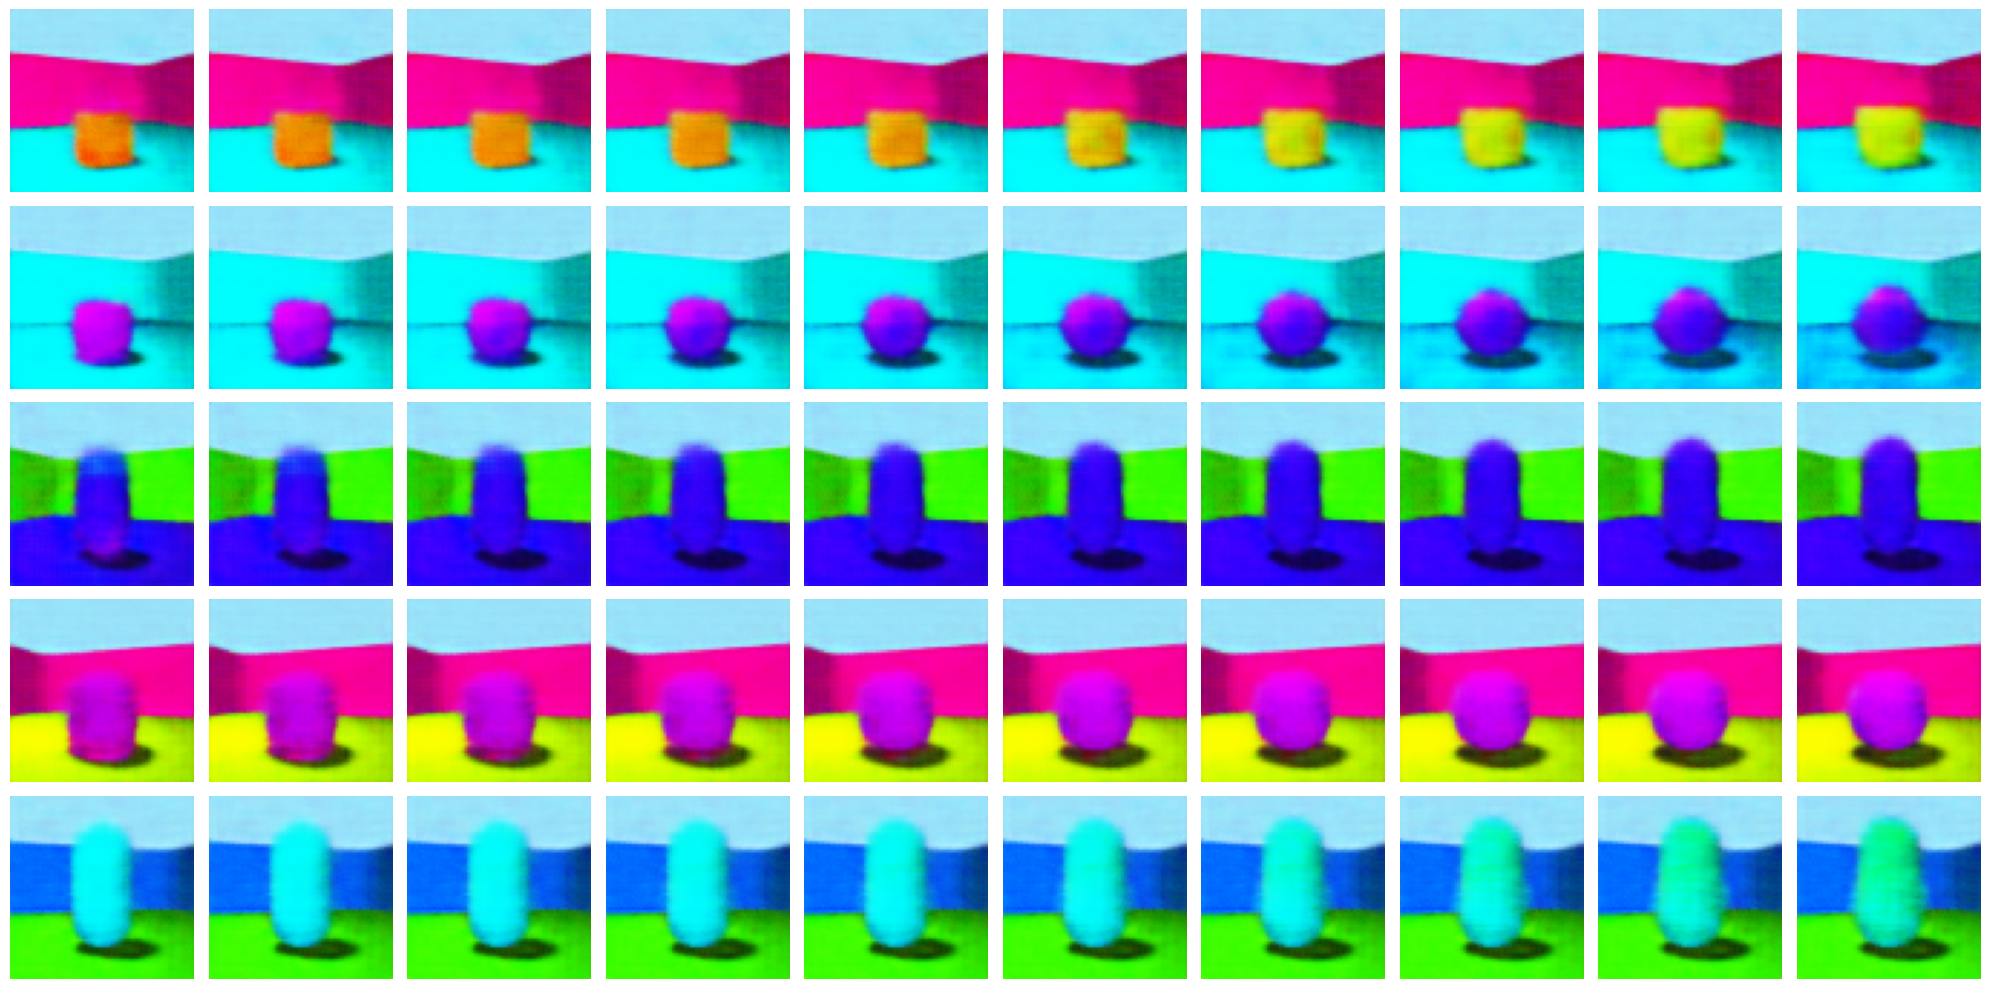

In [86]:
def latent_space_traversal(model, n_samples=5, dim_to_vary=0, variation_range=(-3, 3), steps=10):
    """
    Perform latent space traversal by varying a single dimension of the latent space.
    Parameters:
        model: Trained autoencoder model.
        n_samples: Number of random samples to use.
        dim_to_vary: Latent dimension to vary.
        variation_range: Tuple indicating the range of variation.
        steps: Number of steps in the variation range.
    """
    model.eval()
    variation_values = torch.linspace(variation_range[0], variation_range[1], steps)
    random_indices = np.random.choice(len(val_dataset), n_samples, replace=False)
    images = torch.stack([val_dataset[i][0] for i in random_indices]).to(device)
    
    with torch.no_grad():
        # Pass images through the encoder to get latent representations
        encoded = model.encoder(images)
        latent_shape = encoded.shape  # Save the latent space shape for later
        encoded_flat = encoded.view(n_samples, -1)  # Flatten latent space for manipulation
        
        # Prepare a canvas for results
        plt.figure(figsize=(steps * 2, n_samples * 2))
        
        for i, img_idx in enumerate(random_indices):
            base_latent = encoded_flat[i].clone()
            
            for j, value in enumerate(variation_values):
                varied_latent = base_latent.clone()
                varied_latent[dim_to_vary] = value
                
                # Reshape and decode
                varied_latent_reshaped = varied_latent.view(latent_shape[1:])
                decoded = model.decoder(varied_latent_reshaped.unsqueeze(0))
                decoded_img = decoded.cpu().squeeze(0).permute(1, 2, 0).numpy()
                
                # Plot the resulting image
                plt.subplot(n_samples, steps, i * steps + j + 1)
                plt.imshow(np.clip(decoded_img, 0, 1))  # Ensure valid range
                plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Perform latent space traversal
latent_space_traversal(model, n_samples=5, dim_to_vary=0, variation_range=(-1, 1), steps=10)


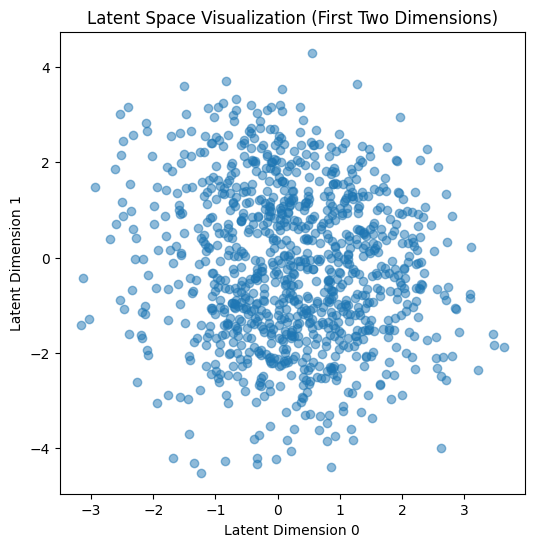

In [87]:
def visualize_latent_space(model, dataset, n_points=1000):
    model.eval()
    indices = np.random.choice(len(dataset), n_points, replace=False)
    images = torch.stack([dataset[i][0] for i in indices]).to(device)
    
    with torch.no_grad():
        encoded = model.encoder(images)  # shape: [n_points, latent_dim, 1, 1]
        latent_vectors = encoded.view(n_points, -1).cpu().numpy()  # shape: [n_points, latent_dim]

    # Plot pairs of latent dimensions (e.g., dim 0 vs dim 1, dim 0 vs dim 2, etc.)
    # Here we will just do a simple scatter of the first two latent dimensions.
    plt.figure(figsize=(6,6))
    plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], alpha=0.5)
    plt.xlabel("Latent Dimension 0")
    plt.ylabel("Latent Dimension 1")
    plt.title("Latent Space Visualization (First Two Dimensions)")
    plt.show()
    
# Call the new visualization function
visualize_latent_space(model, val_dataset, n_points=1000)
